In [9]:
try:
    # Comment out if not using colab.
    from google.colab import drive
    drive.mount('/content/drive')

    # Specific for luca's computer
    %cd "/content/drive/Othercomputers/Min MacBook Air/INFO381-GitHub"
    using_colab = True
except:
    print("Not using Google Colab")
    using_colab = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/Min MacBook Air/INFO381-GitHub


In [10]:
! pip install lime

In [11]:
pip install torchcam


In [13]:
pip install torch

In [14]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import accuracy_score

import torch.nn.functional as F
from utils import get_dataloaders

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

from lime import lime_image
from skimage.segmentation import mark_boundaries
import os

ImportError: cannot import name 'nn' from partially initialized module 'torch' (most likely due to a circular import) (/usr/local/lib/python3.11/dist-packages/torch/__init__.py)

In [ ]:
train_loader, test_loader = get_dataloaders(batch_size=32, split = 'both')
print(test_loader)

In [ ]:
model = models.resnet18(pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load("models/resnet18_cnn.pth"))
model.eval()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
correct = 0
total = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Klassenavn
class_names = ['FAKE', 'REAL']

### LIME





# LIME

In [15]:
def generate_lime(image_path, model, transform, class_names):

    # ---- 1. Last inn bildet ----
    img = Image.open(image_path).convert("RGB")

    # ---- 2. Batch-predict funksjon til LIME ----
    def batch_predict(images):
        model.eval()
        batch = torch.stack([transform(Image.fromarray(im)).float() for im in images], dim=0)
        with torch.no_grad():
            outputs = model(batch)
            probs = F.softmax(outputs, dim=1)
        return probs.detach().cpu().numpy()

    # ---- 3. Prediksjon for tekstinfo ----
    input_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

    print(f"📊 Modellen predikerer at bildet er: {class_names[predicted_class]} (klasse {predicted_class})")

    # ---- 4. Kjør LIME ----
    explainer = lime_image.LimeImageExplainer()

    explanation = explainer.explain_instance(
        np.array(img),
        batch_predict,
        labels=(0, 1),
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # ---- 5. Visualiser ----
    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=False,
        hide_rest=False,
        num_features=10,
        min_weight=0.0
    )

    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"LIME – Predikert: {class_names[predicted_class]}")
    plt.axis("off")
    plt.show()


📊 Modellen predikerer at bildet er: FAKE (klasse 0)


  0%|          | 0/1000 [00:00<?, ?it/s]

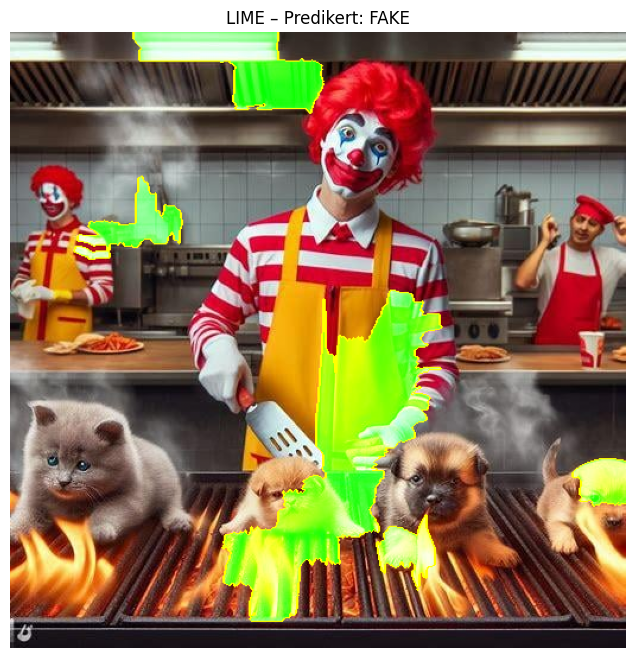

In [ ]:
generate_lime("/content/fake_vs_real/test/fake/1855.jpg", model, transform, class_names)


📊 Modellen predikerer at bildet er: REAL (klasse 1)


  0%|          | 0/1000 [00:00<?, ?it/s]

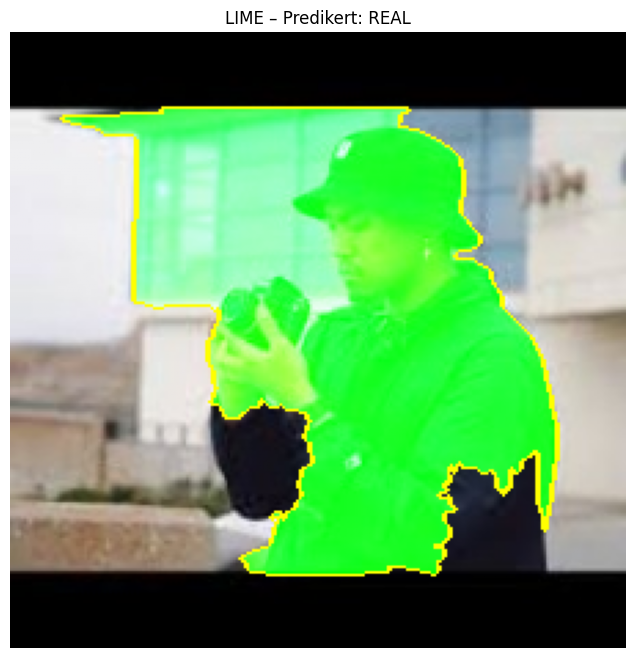

In [ ]:
generate_lime("/content/fake_vs_real/test/real/195.jpg", model, transform, class_names)



📊 Modellen predikerer at bildet er: REAL (klasse 1)


  0%|          | 0/1000 [00:00<?, ?it/s]

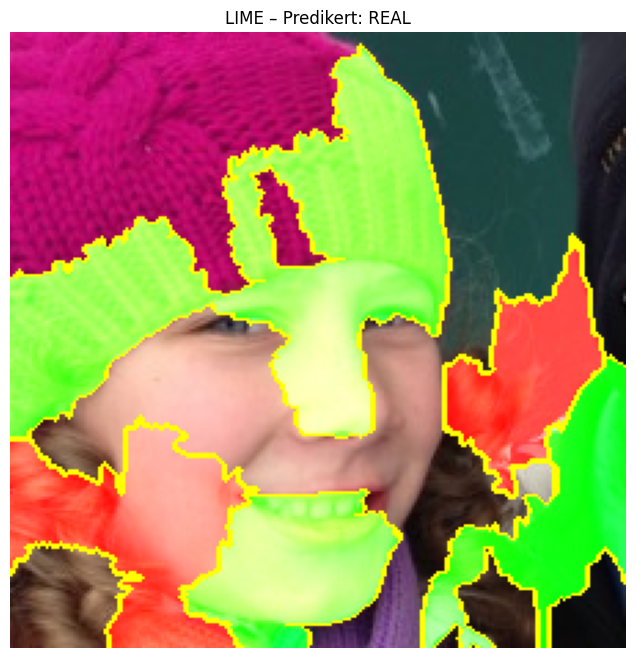

In [ ]:
generate_lime("/content/fake_vs_real/test/real/285.jpg", model, transform, class_names)


# Grad-CAM

In [ ]:
def generate_gradcam(image_path, model, transform, class_names): #Generelle koden

    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)

    cam_extractor = GradCAM(model, target_layer="layer4")

    output = model(input_tensor)
    probs = F.softmax(output, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()

    print(f"📊 Modellen predikerer at bildet er: {class_names[predicted_class]} (klasse {predicted_class})")

    activation_map = cam_extractor(predicted_class, output)

    img_resized = img.resize((512, 512))
    heatmap = to_pil_image(activation_map[0], mode='F')
    result = overlay_mask(img_resized, heatmap, alpha=0.5)

    plt.figure(figsize=(8, 8))
    plt.imshow(result)
    plt.title(f"Grad-CAM – Predikert: {class_names[predicted_class]}")
    plt.axis("off")
    plt.show()


📊 Modellen predikerer at bildet er: FAKE (klasse 0)


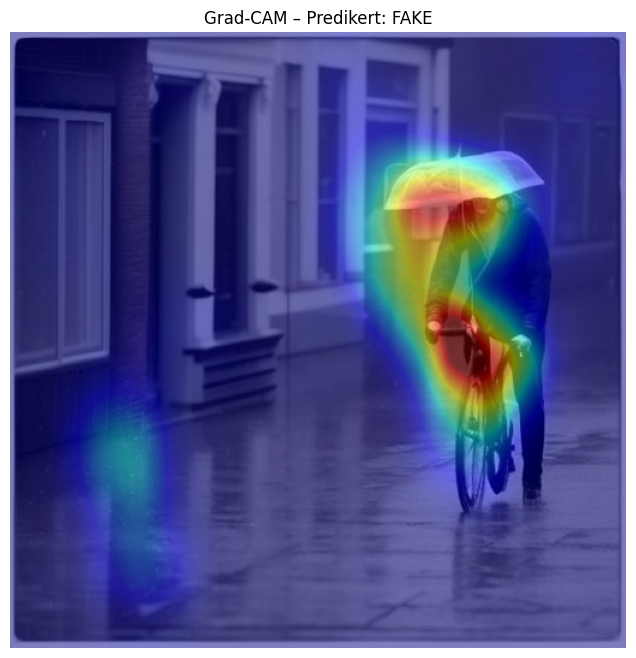

In [ ]:
generate_gradcam("/content/fake_vs_real/test/fake/10031.jpg", model, transform, class_names)


📊 Modellen predikerer at bildet er: REAL (klasse 1)


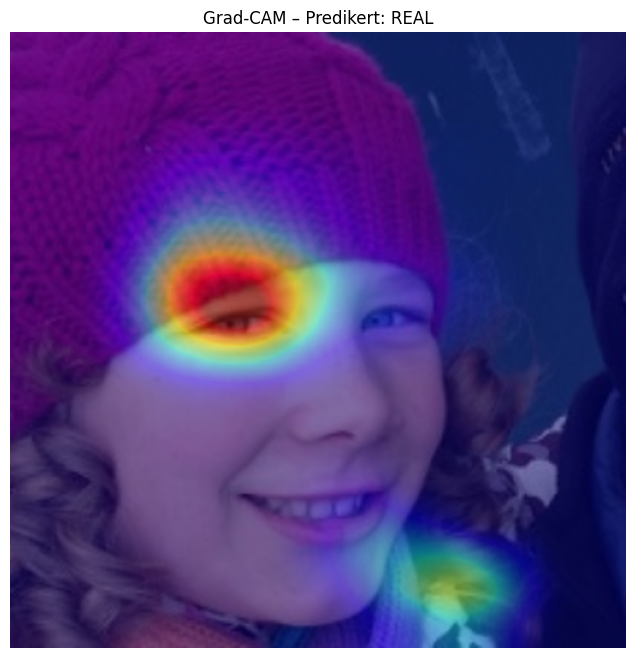

In [ ]:
generate_gradcam("/content/fake_vs_real/test/real/285.jpg", model, transform, class_names)


📊 Modellen predikerer at bildet er: FAKE (klasse 0)


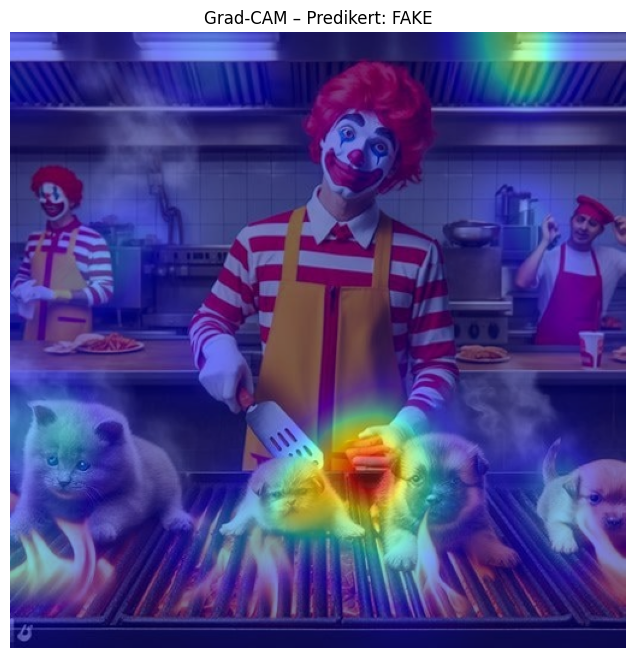

In [ ]:
generate_gradcam("/content/fake_vs_real/test/fake/1855.jpg", model, transform, class_names)

📊 Modellen predikerer at bildet er: REAL (klasse 1)


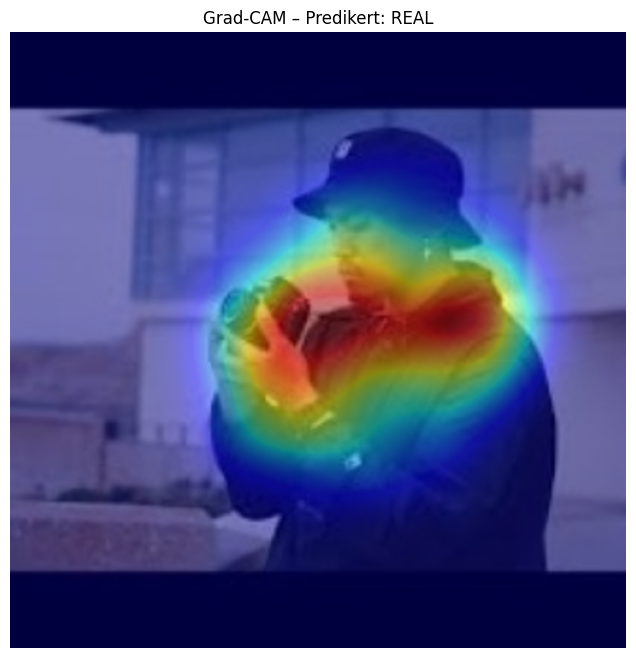

In [ ]:
generate_gradcam("/content/fake_vs_real/test/real/195.jpg", model, transform, class_names)

📊 Modellen predikerer at bildet er: FAKE (klasse 0)


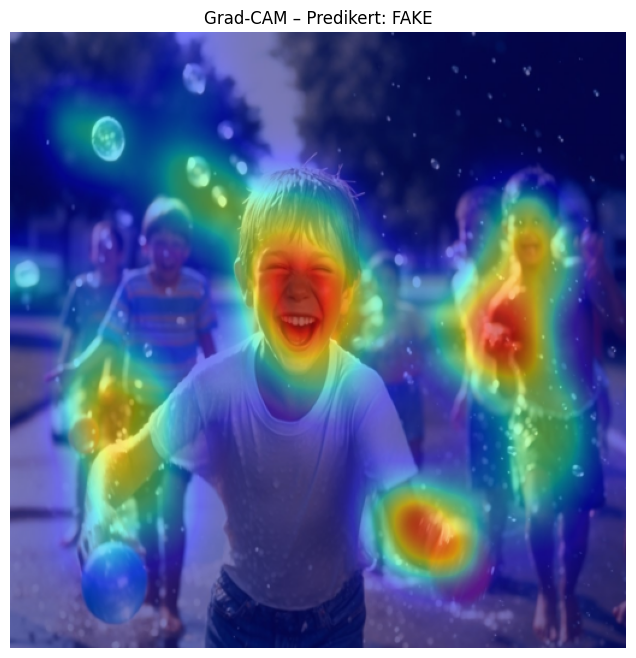

In [ ]:
generate_gradcam("/content/fake_vs_real/test/fake/1702.jpg", model, transform, class_names)

📊 Modellen predikerer at bildet er: FAKE (klasse 0)


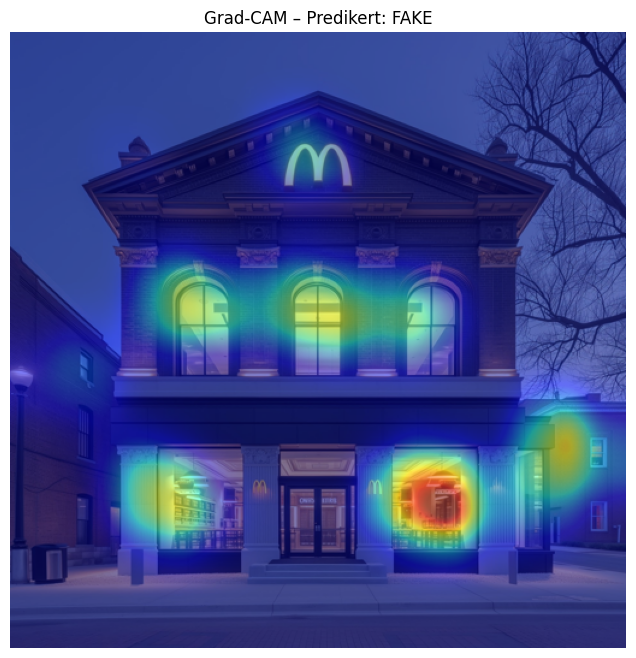

In [ ]:
generate_gradcam("/content/fake_vs_real/test/fake/1759.jpg", model, transform, class_names)

📊 Modellen predikerer at bildet er: FAKE (klasse 0)


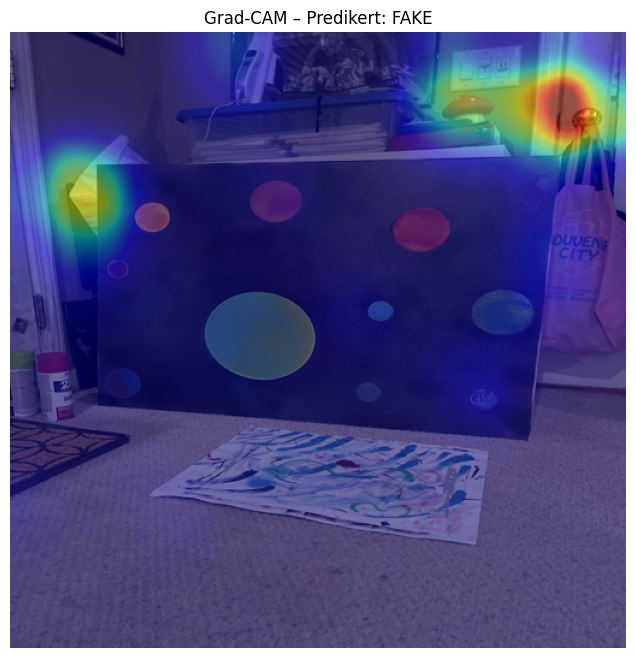

In [ ]:
generate_gradcam("/content/fake_vs_real/test/real/4gifq4txue6a1.jpg", model, transform, class_names)

📊 Modellen predikerer at bildet er: REAL (klasse 1)


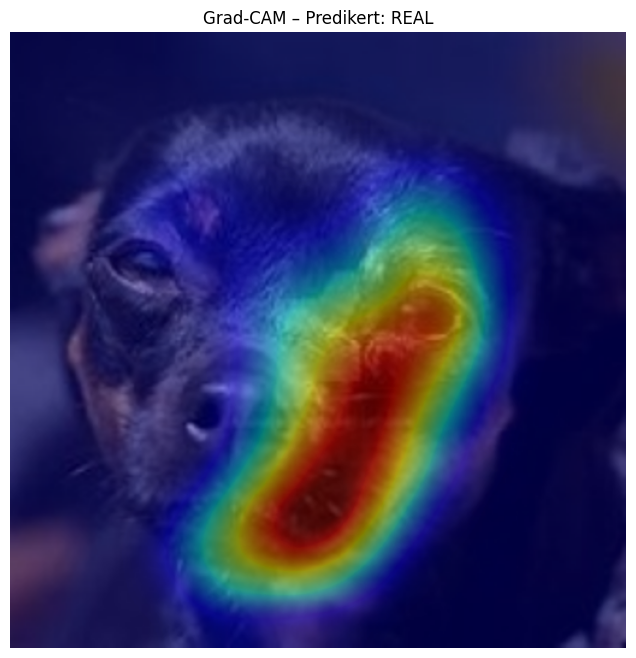

In [ ]:
generate_gradcam("/content/fake_vs_real/test/real/463.jpg", model, transform, class_names)

In [3]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:

# Last inn et ferdigtrent CNN (ResNet)
model.eval()

# Last inn bilde
image = Image.open("/content/fake_vs_real/test/real/463.jpg").convert('RGB')

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)  # Add batch dim
input_tensor.requires_grad = True  # Viktig for Vanilla Gradient

# Forward pass
output = model(input_tensor)

# Finn klassen med høyest score
target_class = output.argmax()

# Nullstill grad
model.zero_grad()

# Backward pass - finn gradienter
output[0, target_class].backward()

# Hent gradienter fra input
gradients = input_tensor.grad.data[0]

# Gjør om til numpy array
gradients = gradients.permute(1, 2, 0).detach().numpy()

# Gjør om gradientene til grayscale heatmap
grayscale_gradients = np.mean(np.abs(gradients), axis=2)

# Visualiser
plt.imshow(grayscale_gradients, cmap='hot')
plt.title("Vanilla Gradient Visualization")
plt.axis('off')
plt.show()
